In [78]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import tree

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aramanujam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aramanujam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Ingestion

In [38]:
langs = {'English': 'en', 'Spanish': 'es', 'French': 'fr','Portuguese': 'pt', 'German': 'de', 'Italian': 'it'}
books = {}

for lang, code in langs.items():
    r = requests.get(f'https://gutendex.com/books/?languages={code}')
    results = r.json()['results'][:5]
    ids = [book['id'] for book in results]
    books[lang] = ids

In [29]:
for lang, code in langs.items():
    lang_folder = f'books/{code}'
    os.makedirs(lang_folder, exist_ok=True)
    for book in books[lang]:
        r = requests.get(f'https://www.gutenberg.org/files/{book}/{book}-0.txt')
        raw = r.text
        clean_raw = clean_text(raw, lang)
        with open(f'{lang_folder}/{code}-{book}-clean.txt', 'w', encoding='utf-8') as f:
            f.write(clean_raw)

## Data Cleaning

In [21]:
def clean_text(text, lang):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stopwords.words(lang.lower())]
    clean_text = ' '.join(words)
    return clean_text

In [48]:
# spent some time manually sifting through texts and removing corpi that didn't work
# and identified some that could were long enough in length to require splitting
max_words = 2000
for lang, code in langs.items():
    corpi = os.listdir(f'books/{code}')
    for book in corpi:
        if code in book:
            with open(f'books/{code}/{book}', 'r', encoding='utf-8') as f:
                text = f.read()
                num_words = len(text.split())
                if num_words > max_words:
                    # Split the text into chunks
                    chunks = [text[i:i+max_words] for i in range(0, len(text), max_words)]
                    # Write each chunk to a new file
                    for i, chunk in enumerate(chunks):
                        with open(f'books/{code}/{code}_chunk_{i+1}.txt', 'w', encoding='utf-8') as chunk_file:
                            chunk_file.write(chunk)

## Model Training

In [51]:
# Load the text chunks and labels
chunks = []
labels = []
for lang, code in langs.items():
    corpi = os.listdir(f'books/{code}')
    for book in corpi:
        if code in book and 'chunk' in book:
            with open(f'books/{code}/{book}', 'r', encoding='utf-8') as f:
                text = f.read()
                chunks.append(text)
                labels.append(lang)

# Convert the text chunks to numerical features using a CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(chunks)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train a decision tree classifier on the training set
clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)

## Model Evaluationn

Accuracy: 0.9529411764705882
Precision: 0.9612386963917987
Recall: 0.9529411764705882
F1-score: 0.9542106952523397


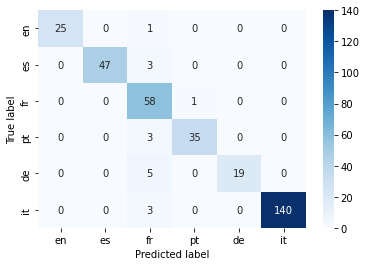

In [70]:
# Make predictions on test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=langs.values(), yticklabels=langs.values())

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.plot()
plt.savefig('confusion.svg')

In [79]:
tree_rules = export_text(clf)
print(tree_rules)

|--- feature_5565 <= 0.50
|   |--- feature_32902 <= 0.50
|   |   |--- feature_65663 <= 0.50
|   |   |   |--- feature_50323 <= 0.50
|   |   |   |   |--- feature_70161 <= 1.00
|   |   |   |   |   |--- feature_21217 <= 0.50
|   |   |   |   |   |   |--- feature_25052 <= 0.50
|   |   |   |   |   |   |   |--- feature_20891 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_51079 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_47167 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: German
|   |   |   |   |   |   |   |   |   |--- feature_47167 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: Portuguese
|   |   |   |   |   |   |   |   |--- feature_51079 >  0.50
|   |   |   |   |   |   |   |   |   |--- class: Italian
|   |   |   |   |   |   |   |--- feature_20891 >  0.50
|   |   |   |   |   |   |   |   |--- class: French
|   |   |   |   |   |   |--- feature_25052 >  0.50
|   |   |   |   |   |   |   |--- class: Portuguese
|   |   |   |   |   |--- feature_21217 >  0

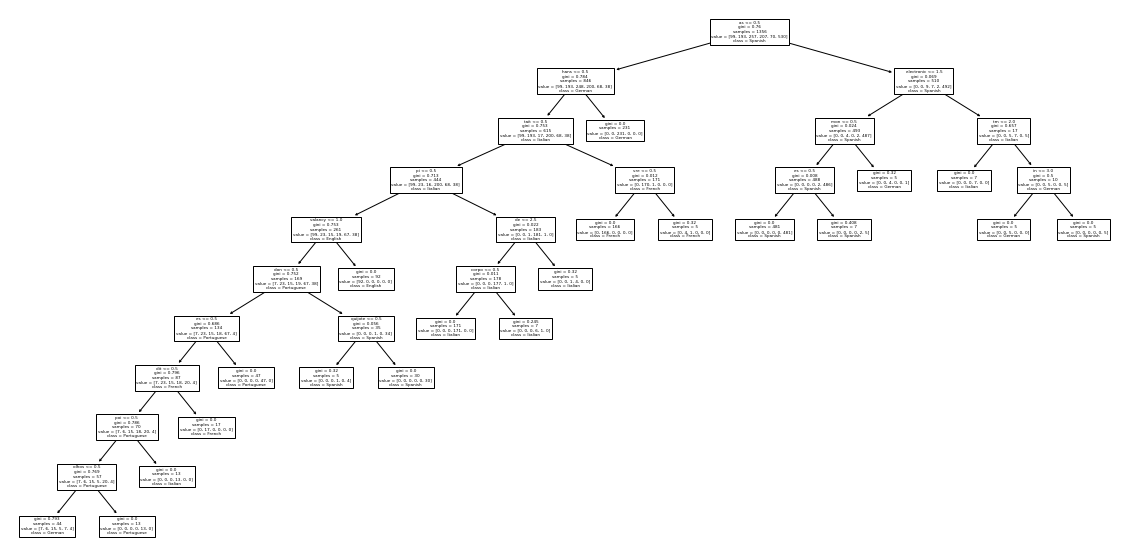

In [82]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(clf, ax=ax, feature_names=vectorizer.get_feature_names(), class_names=clf.classes_)
plt.plot()
plt.savefig('architecture_2.svg')